# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [1]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 97.3 MB/s eta 0:

In [2]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [4]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [6]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 4, 1954, 256, 10, 8, 256, 7, 4, 52, 68, 3]
shuffled sentecen:  [2, 8, 256, 10, 1954, 4, 256, 4, 7, 68, 52, 3]


Let us look at detokenized data:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> the illinois river is a river in the united states <end>
shuffled sentence:  <start> a river is illinois the river the in states united <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [8]:
max_sequence_len = max([len(x) for x in original_data])
print("max_sequence_len: ", max_sequence_len)

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

max_sequence_len:  32


In [ ]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

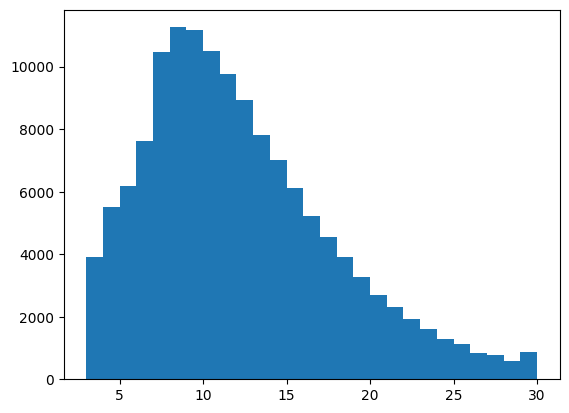

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [9]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p), len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 10K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

## Libraries
Installing keras_nlp and imporintg useful classes

In [10]:
!pip install keras-nlp --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.3 MB/s eta 0:00:00


In [11]:
# importing the Transformer layers that will be used throughout the model
from keras_nlp.layers import TransformerEncoder, TransformerDecoder
# importing tensorflow, the layers used, the model class,
# the loss function, the optimizer and the callback functions
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from keras.utils import plot_model

## Data Augmentation
I will augment the training data performing more shuffling

In [12]:
def data_augmentation(num_loop, x_train, c_train, y_train, sos, eos):
  # saving the input
  x_train_aug = x_train.copy()
  c_train_aug = c_train.copy()
  y_train_aug = y_train.copy()

  for _ in range(num_loop):
    # shuffle the data
    shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in x_train]
    shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
    # saving the augmented sets
    x_train_aug += x_train
    c_train_aug += shuffled_data
    y_train_aug += y_train

  return (x_train_aug, c_train_aug, y_train_aug)

In [ ]:
x_train_aug, c_train_aug, y_train_aug = data_augmentation(2, x_train, c_train, y_train, sos, eos)
# x_train, c_train, y_train = data_augmentation(2, x_train, c_train, y_train, sos, eos)
print("x_train_aug size:", len(x_train_aug))
assert(len(x_train_aug)==len(c_train_aug)==len(y_train_aug))

In [ ]:
# example of results
i = np.random.randint(len(x_train_aug)/3)
print("original sentence: ",x_train_aug[i])
print("shuffled sentence 1: ",c_train_aug[i])
print("shuffled sentence 2: ",c_train_aug[i + len(x_train)])
print("shuffled sentence 3: ",c_train_aug[i + len(x_train)*2])

print('\n')
print("original sentence: ",tokenizer.sequences_to_texts([x_train_aug[i]])[0])
print("shuffled sentence 1: ",tokenizer.sequences_to_texts([c_train_aug[i]])[0])
print("shuffled sentence 2: ",tokenizer.sequences_to_texts([c_train_aug[i + len(x_train)]])[0])
print("shuffled sentence 3: ",tokenizer.sequences_to_texts([c_train_aug[i + len(x_train)*2]])[0])

original sentence:  [2, 1230, 53, 43, 216, 7, 4, 287, 66, 117, 64, 149, 3898, 3]
shuffled sentence 1:  [2, 149, 3898, 7, 53, 4, 43, 216, 66, 117, 64, 287, 1230, 3]
shuffled sentence 2:  [2, 1230, 7, 117, 216, 43, 3898, 287, 149, 64, 53, 66, 4, 3]
shuffled sentence 3:  [2, 64, 3898, 43, 287, 53, 216, 66, 1230, 7, 117, 149, 4, 3]


original sentence:  <start> chicago had first place in the 2018 time out city life index <end>
shuffled sentence 1:  <start> life index in had the first place time out city 2018 chicago <end>
shuffled sentence 2:  <start> chicago in out place first index 2018 life city had time the <end>
shuffled sentence 3:  <start> city index first 2018 had place time chicago in out life the <end>


## Data processing
I will transform the label data in a one hot encoding composed of 32 digits.

Example:
if a word is [100, 58, 0, 2, 8, 85, 7, 0, 9, 0], I want to obtain [7, 5, 0, 1, 3, 6, 2, 0, 4, 0]. This array of 10 words is "normalized" in such a way that the smallest number is 0 and the next smallest number is represented by 1 (such that in the array there are all consecutive integers): in the example above, in the second array, we have all integers between 0 and 7. In the example above it is possible to see that the 0s in the first array are represented by 0s in the second array (because zero is the smallest number), instead 100 is represented by a 7.

To do it I will use the ```LabelEncoder``` of the scikit learn library.

Then I want to obtain a one hot encoded version of this array.
To do it I will use the ```to_categorical``` function of keras. To this function I set the parameter num_classes=32 such that I will obtain an array of 32 numbers for each words (because each word could be composed of at most 32 different tokens).

I perform this operation because the model will produce in output a 32x32 matrix and in this way the comparison is easier (moreover we could use the ```CategoricalCrossentropy``` as loss function).

In [16]:
# example
le = LabelEncoder()
a = np.array([2, 1230, 53, 43, 216, 7, 4, 287, 66, 117, 64, 149, 3898, 3])
le.fit(a)
b = le.transform(a)
to_categorical(b, num_classes=32)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [12]:
def get_new_sequence(sequence, max_sequence_len=32, vocabulary=10000):
  new_sequence = []
  print("data to process: ", len(sequence))
  i = 0

  for x in sequence:
    i += 1
    if i%10000 == 0:
      print("processed: ", i)

    le = LabelEncoder()
    le.fit(x)
    new_x = le.transform(x)
    
    new_sequence.append(new_x)

  # obtain the one hot encoded version
  new_sequence = [to_categorical(new_x, num_classes=max_sequence_len) 
                  for new_x in new_sequence]
  return new_sequence

x_train_one_hot = np.array(get_new_sequence(x_train))
x_test_one_hot = np.array(get_new_sequence(x_test))

data to process:  96110
processed:  10000
processed:  20000
processed:  30000
processed:  40000
processed:  50000
processed:  60000
processed:  70000
processed:  80000
processed:  90000
data to process:  41191
processed:  10000
processed:  20000
processed:  30000
processed:  40000


In [18]:
print("x_train_one_hot shape", x_train_one_hot.shape)
print("x_test_one_hot shape", x_test_one_hot.shape)

x_train_one_hot shape (96110, 32, 32)
x_test_one_hot shape (41191, 32, 32)


## Defining the model
The model developed is composed by an Input layer, an Embedding layer, 4 TransformerEncoder layers and a Dense layer.

The **input** layer will always receive a sentence of 32 tokens.

The **embedding** layer will create an embedding of the input.
Its hyper parameters are the dimension of the vocabulary, the dimensione of the embedding and mask_zero (that is False such that all the tokens are considered, also the zeros)

The **Transformer Encoders** will process the information. The hyper parameter are the internal dimensionality of the FeedForward layer, the number of parallel attention layers and the dropout rate.

The **Dense** layer has 32 units (as the maximum number of different tokens that could be present in a sentence). The activation function is a softmax and the final output is a 32x32 matrix. The output is composed by 32 arrays of probability: each array represent a word and in it there are 32 probabilities representing each a possible different word of the received input.

Doing ```tf.argmax(pred, axis=-1)``` on the output of the network we will obtain an array of this type ```[1, 5, 11, 5, 9, 11, 11, 11, 7, 10, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]``` where each number represent a word with respect to the ground truth (in this example the "denormalized" version of the ground truth is ```[1185, 162, 1039, 759, 70, 19, 4, 785, 4477, 3854, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]```, instead the "normalized" version is ```[ 9, 5, 8, 6, 4, 3, 2, 7, 11, 10, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]```).

To obtain, from the output of the network, the "denormalized" tokens, I will build a function in the last part of the notebook.


In [27]:
def get_model(num_layer, embedding_dim, feedforward_dim, num_heads, dropout, input_shape, output_shape, vocabulary_dim=10000):
  input = Input(shape=input_shape)
  embedding_layer = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input)
  encoder = embedding_layer
  
  for _ in range(num_layer):
    encoder = TransformerEncoder(feedforward_dim, num_heads, dropout=dropout)(encoder)

  # output = Dense(vocabulary_dim, activation='softmax')(encoder)
  # output = Dense(output_shape, activation='relu')(output)
  # output = Dense(output_shape, activation='relu')(output)
  output = Dense(output_shape, activation='softmax')(encoder)

  model = Model(input, output)
  model.summary()
  return model

In [28]:
num_layer = 4 #12
embedding_dim = 32 #64 #256 #768 #32
num_heads = 8 #8 #12
feedforward_dim = 128 #256 #1024 #512 #3072=embedding*4
dropout = 0.15
output_shape = 32 #max_sequence_len
vocabulary_dim = 10000
# max_sequence_len = 32

model = get_model(num_layer=num_layer, embedding_dim=embedding_dim,
                  feedforward_dim=feedforward_dim, num_heads=num_heads, dropout=dropout,
                  input_shape=(max_sequence_len,),
                  output_shape=output_shape,
                  vocabulary_dim=vocabulary_dim)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 32, 32)            320000    
                                                                 
 transformer_encoder_4 (Tran  (None, 32, 32)           12704     
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_5 (Tran  (None, 32, 32)           12704     
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_6 (Tran  (None, 32, 32)           12704     
 sformerEncoder)                                                 
                                                           

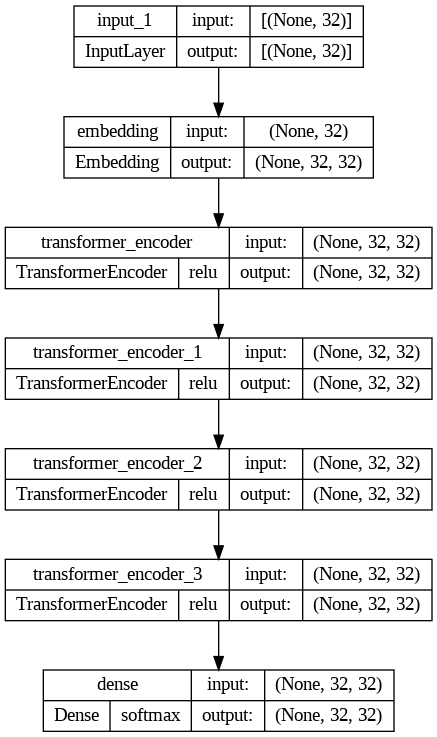

In [15]:
plot_model(model, show_shapes=True, show_layer_activations=True, to_file='model.png')

## Training
The optimizer used is ```Adam```. The loss function (as previous anticipated) is the ```CategoricalCrossentropy```, such that we could compare the output of the model (a matrix of probabilities) with the ground truth. Obviously the ```from_logits``` parameters is False.

In [16]:
import matplotlib.pyplot as plt

def display_history(history, accuracy, accuracy_name=None):
    mse_training = history.history['loss']
    mse_val = history.history['val_loss']
    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    if accuracy:
      acc_training = history.history[accuracy_name]
      acc_val = history.history[f"val_{accuracy_name}"]
      # and of the accuracy
      plt.plot(acc_training)
      plt.plot(acc_val)
      plt.grid()
      plt.title('Accuracy during training')
      plt.xlabel('Epoch')
      plt.legend(['Training', 'Validation'])
      plt.show()

In [29]:
optimizer = Adam(learning_rate=4e-4)
loss = CategoricalCrossentropy(from_logits=False)

model.compile(loss=loss, optimizer=optimizer)

In [18]:
!mkdir ckpts

### Fit method
We pass to the fit method as data ```c_train``` (the shuffled sentences) and as labels ```x_train_one_hot``` (the one hot version of ```x_train```). The validation split is 0.1 and the data are shuffled. The callbacks used are ```EarlyStopping``` (to terminate the training if after 5 epochs there are no improvements of the validation loss) and ```ModelCheckpoint``` (to save the best weights).

In [30]:
epochs = 20
batch_size = 512
accuracy_name = "loss"

earlyStopping = EarlyStopping(monitor = f"val_{accuracy_name}", mode = 'min', \
                              patience = 5, restore_best_weights = True)
modelCheckpoint = ModelCheckpoint('./ckpts/cp-{epoch:04d}.ckpt', \
                                  monitor=f"val_{accuracy_name}", mode='min', \
                                  save_weights_only = True, save_best_only = True, save_freq="epoch")

history = model.fit(c_train, x_train_one_hot, validation_split=0.1, \
                    shuffle=True, epochs=epochs, batch_size=batch_size, \
                    callbacks=[earlyStopping, modelCheckpoint])

model.save_weights('weights.hdf5')

Epoch 1/20
169/169 [==============================] - 38s 140ms/step - loss: 2.5763 - val_loss: 2.3690
Epoch 2/20
169/169 [==============================] - 11s 66ms/step - loss: 2.3272 - val_loss: 2.2504
Epoch 3/20
169/169 [==============================] - 11s 63ms/step - loss: 2.2486 - val_loss: 2.2132
Epoch 4/20
169/169 [==============================] - 8s 50ms/step - loss: 2.2182 - val_loss: 2.1906
Epoch 5/20
169/169 [==============================] - 7s 44ms/step - loss: 2.2017 - val_loss: 2.1942
Epoch 6/20
169/169 [==============================] - 9s 53ms/step - loss: 2.1916 - val_loss: 2.1795
Epoch 7/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1840 - val_loss: 2.1738
Epoch 8/20
169/169 [==============================] - 9s 53ms/step - loss: 2.1772 - val_loss: 2.1752
Epoch 9/20
169/169 [==============================] - 7s 41ms/step - loss: 2.1709 - val_loss: 2.1748
Epoch 10/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1649 - va

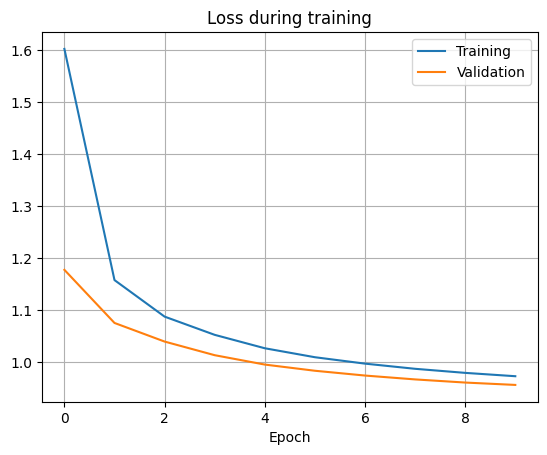

In [20]:
display_history(history, False)

### Loading of the best weights

In [ ]:
latest = tf.train.latest_checkpoint('ckpts')
print(latest)
model.load_weights(latest)

ckpts/cp-0056.ckpt


In [ ]:
model.load_weights('weights.hdf5')

## Testing the model
Division of the test set such that we could use a random part of it (more than 10k samples).

In [22]:
print(x_test.shape)
_, x_test_10k, _, c_test_10k, _, y_test_10k, _, x_test_one_hot_10k = \
  train_test_split(x_test, c_test, y_test, x_test_one_hot, 
                  test_size = 0.25, random_state = 42)
print(x_test_10k.shape)

(41191, 32)
(10298, 32)


### Accuracy function
The accuracy function keep in input ```x_test_10k, x_test_one_hot_10k, preds```. For each element in the test set: ```tf.argmax()``` is computed on ```x_test_one_hot_10k[i]``` and ```preds[i]``` to obtain the tokens that make the sentence, then it is cut to remove the start token, the end token and any padding (if present), and at the end is computed the score. The final result is the average of the scores.

In [25]:
def my_accuracy(labels_original, labels, preds):
  score_tot = 0
  for i in range(len(labels)):
    label_original = labels_original[i]
    pred = preds[i]
    label = labels[i]
    # print(f"pred:\n{pred}\nlabel:\n{label}")

    predicted_id = tf.argmax(pred, axis=-1)
    label_id = tf.argmax(label, axis=-1)
    
    # retrieve the index of the stop token
    idx_stop = np.where(label_original == 3)

    p = predicted_id
    l = label_id

    # cut the sentences up to the stop token
    # and remove the start token
    try:
      l = label_id[1:idx_stop[0][0]]
      p = predicted_id[1:idx_stop[0][0]]
    except:
      print("error")

    # print(p, l, "\n")
    #print(score(l.numpy(), p.numpy()))
    score_tot += score(l.numpy(), p.numpy())

  return score_tot / len(labels)

In [31]:
# generating data
predictions = model.predict(c_test_10k)

322/322 [==============================] - 3s 7ms/step


In [32]:
# obtain the score
point = my_accuracy(x_test_10k, x_test_one_hot_10k, predictions)
print("score: ", point)

score:  0.1499310946366505


### Example of output

In [77]:
# function to retrieve the "denormalized" tokens
def transform_output(label_original, label, pred):
  res = []
  map = dict(zip(label, label_original))
  print(pred)
  for i in range(len(pred)):
    res.append(map.get(pred[i], default=0))
  return res


In [78]:
num = 1
preds = model.predict(c_test_10k[:num])
print("preds shape: ", preds.shape)
predicted_id = tf.argmax(preds[0,1], axis=-1)
print("\n \"normalized\" sentence: ", predicted_id)

label_id = np.argmax(x_test_one_hot_10k[num], axis=-1)
denormalized_version = transform_output(x_test_10k[num], label_id, predicted_id)
print("\n denormalized sentence: ", denormalized_version)
print(" ground truth: ", x_test_10k[num])

print("\nscore of this sample:")
print(my_accuracy(x_test_10k[num], x_test_one_hot_10k[num], preds))

1/1 [==============================] - 0s 26ms/step
preds shape:  (1, 32, 32)

 "normalized" sentence:  tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


TypeError: ignored